# TFIDF - NMF analysis
- define what a document is
    - one uninterrupted speech made by speaker
    - all speeches made by speaker
    - all speeches made on the same date
- preprocess text
- count TFIDF
- do dimensionality reduciton/topic clustering with NNMF
- look for appropriate dimension with knee method
- try visualizing document-topic in 2D or 3D

Do this for both **euroleaks** and **communiques**, then do a comparative analysis if approapriate.

In [316]:
import re
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

In [317]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)

In [318]:
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

## helper functions

In [319]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.lemma_.lower() in nlp.Defaults.stop_words\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

# Euroleaks

## document = speech

In [432]:
leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# preprocess
leaks_documents = [
    ' '.join([token.lemma_.lower() for sentence in nlp(doc).sents for token in sentence
              if filter_token(token)
             ])
             for doc in leaks.speech.values
]

# leave out empty documents
leaks_documents = [d for d in leaks_documents if len(d)>1]

# apply collocations
leaks_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in leaks_documents]

# tfidf
leaks_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=10,
                                   max_df=0.75,
                                   smooth_idf=True,
                                   sublinear_tf=False)

leaks_X = leaks_vectorizer.fit_transform(leaks_documents)

- **TODO**: what are good min_df and max_df values? task-specific

matrix shape: (538, 497)


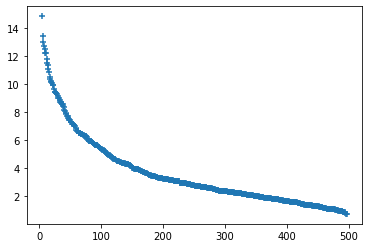

In [433]:
print(f'matrix shape: {leaks_X.shape}')

leaks_tfidf = leaks_X.sum(axis =0).A1
leaks_idf = leaks_vectorizer.idf_

plt.scatter(range(len(leaks_tfidf))[5:], np.sort(leaks_tfidf)[::-1][5:], marker='+')

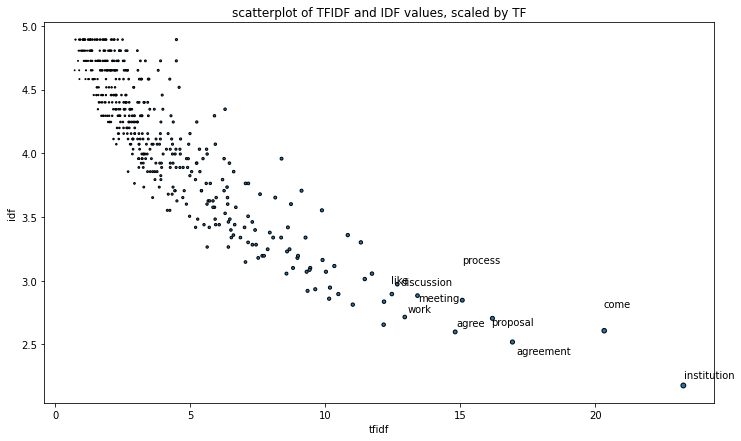

In [434]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(leaks_tfidf, leaks_idf, s=leaks_tfidf, edgecolors='black', label='tfidf')
#ax.legend()
ax.set_xlabel('tfidf')
ax.set_ylabel('idf')
ax.set_title('scatterplot of TFIDF and IDF values, scaled by TF')

# annotate words with highest tfidf
first_k = 10
sort_ix = np.argsort(leaks_tfidf)[::-1]
for ix in sort_ix[:first_k]:
    s = leaks_vectorizer.get_feature_names()[ix]
    jiggle_x = np.random.normal(0,0.1)
    jiggle_y = np.random.normal(0,0.1)
    ax.text(leaks_tfidf[ix]+jiggle_x, leaks_idf[ix]+jiggle_y, s)

In [435]:
for word in np.array(leaks_vectorizer.get_feature_names())[sort_ix][:10]:
    print(word)

institution
come
agreement
proposal
process
agree
meeting
work
discussion
like


### NMF topic model
- https://shravan-kuchkula.github.io/nlp/topic-modeling/#build-nmf-model-using-sklearn

In [693]:
# get topics with their terms and weights
def my_get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])

    topics = [{term: float(weight) for term, weight in zip(terms, term_weights)} for terms, term_weights in zip(sorted_terms, sorted_weights)]
    
    return topics

# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])

    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]

    return topics


# prints components of all the topics
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
        print()

# prints components of all the topics
# obtained from topic modeling
def get_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     num_terms=None):

    topic_terms = []

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

def getTermsAndSizes(topic_display_list_item):
    terms = []
    sizes = []
    for term, size in topic_display_list_item:
        terms.append(term)
        sizes.append(size)
    return terms, sizes

In [439]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=3, init='nndsvd', alpha=0.1, l1_ratio=0.5)
nmf_output = nmf.fit_transform(leaks_X)

nmf_feature_names = leaks_vectorizer.get_feature_names()
nmf_weights = nmf.components_

In [440]:
nmf_weights.shape

(3, 497)

In [441]:
topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)

print_topics_udf(topics, total_topics=3, num_terms=20, display_weights=True)

Topic #1 with weights
[('institution', 0.6), ('agreement', 0.48), ('process', 0.39), ('work', 0.37), ('agree', 0.33), ('list', 0.3), ('time', 0.29), ('reform', 0.28), ('discussion', 0.28), ('government', 0.27), ('issue', 0.26), ('measure', 0.26), ('meeting', 0.26), ('greece', 0.26), ('way', 0.25), ('greek', 0.25), ('clear', 0.24), ('term', 0.24), ('like', 0.23), ('eurogroup', 0.23)]

Topic #2 with weights
[('come', 2.38), ('end', 0.1), ('communication', 0.08), ('proposal', 0.07), ('conclusion', 0.06), ('hour', 0.06), ('day', 0.04), ('assessment', 0.03), ('round', 0.03), ('athens', 0.03), ('difficult', 0.03), ('prepare', 0.02), ('try', 0.02), ('sorry', 0.02), ('proceed', 0.02), ('institution', 0.02), ('agenda', 0.01), ('stop', 0.01), ('reconvene', 0.01), ('available', 0.01)]

Topic #3 with weights
[('proposal', 1.0), ('referendum', 0.89), ('letter', 0.66), ('program', 0.42), ('new', 0.34), ('second_letter', 0.31), ('political', 0.23), ('table', 0.21), ('extension', 0.2), ('course', 0.19

In [442]:
nmf_output[:5]

array([[0.0064556 , 0.        , 0.        ],
       [0.14537443, 0.        , 0.00634698],
       [0.11854351, 0.        , 0.07191478],
       [0.1568777 , 0.        , 0.        ],
       [0.01268996, 0.        , 0.        ]])

In [427]:
leaks.speech[0]

'… of your responses or questions. And can I first, first ask the Commission,  or Pierre, to uh, give their headlines.'

## document = speaker

In [458]:
# make a list of all unidentified speakers

unidentified_speakers = [s for s in speakers if 'speaker' in s]
unidentified_speakers += [
    'irina',
    'kian',
    'male',
    'martin',
    'nabil',
    #'tooma', # I just know that he represents Finland
    'tropa'
]

In [459]:
leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by speaker
grouped = leaks.drop(columns=['date']).groupby('speaker').apply(lambda s: ' '.join(s.speech))
# get speaker labels
speakers = grouped.index

# get identified speaker labels
identified_speakers = speakers[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]
# filter out unidentified speakers
grouped = grouped[speakers.to_series().apply(lambda s: s not in unidentified_speakers)]

# preprocess
leaks_documents = [
    ' '.join([token.lemma_.lower() for sentence in nlp(doc).sents for token in sentence
              if filter_token(token)
             ])
             for doc in grouped.values
]

# leave out empty documents
leaks_documents = [d for d in leaks_documents if len(d)>1]

print(f'There are {len(leaks_documents)} documents.')

# apply collocations
leaks_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in leaks_documents]

# need to filter out unidentified speakers first?

# tfidf
leaks_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2,
                                   max_df=0.75,
                                   smooth_idf=True,
                                   sublinear_tf=False)

leaks_X = leaks_vectorizer.fit_transform(leaks_documents)

There are 31 documents.


In [460]:
int(31 * 0.75)

23

In [461]:
# speakers that have less than cutoff tokens after preprocessing
cutoff = 50
speakers[speakers.to_series().apply(lambda s: s not in unidentified_speakers)][np.array([len(d.split()) for d in leaks_documents]) < cutoff]

Index(['dušan mramor', 'johan van overtveldt', 'jānis reirs'], dtype='object', name='speaker')

What are good min_df and max_df values? Need to choose them specifically for the task at hand; meaning clustering speakers.

Therefore, I want to remove words which have low discriminatory power between speaker.

matrix shape: (31, 1649)


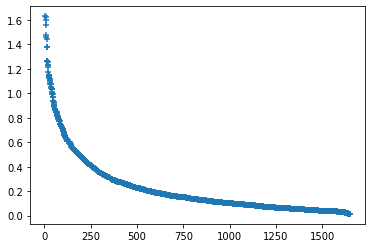

In [462]:
print(f'matrix shape: {leaks_X.shape}')

leaks_tfidf = leaks_X.sum(axis =0).A1
leaks_idf = leaks_vectorizer.idf_

plt.scatter(range(len(leaks_tfidf))[5:], np.sort(leaks_tfidf)[::-1][5:], marker='+')

In [463]:
leaks_tfidf = leaks_X.sum(axis =0).A1
sort_ix = np.argsort(leaks_tfidf)[::-1]

for word in np.array(leaks_vectorizer.get_feature_names())[sort_ix][:10]:
    print(word)

measure
program
agree
discussion
reform
process
time
government
list
greek


### NMF

#### cross validation to find number of latent dimenstions

In [667]:
# adapted from:
# https://gist.github.com/ahwillia/65d8f87fcd4bded3676d67b55c1a3954
# nonnegfac: https://github.com/kimjingu/nonnegfac-python

import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from nonnegfac.nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist


def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    
    if A.ndim == 1:
        A = A[:,None]
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor # dimension mismatch here
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    return X.T


def cv_nmf(data, rank, M=None, p_holdout=0.3):
    """Fit NMF while holding out a fraction of the dataset.
    """

    solver = censored_nnlstsq

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize U randomly
    U = np.random.rand(data.shape[0], rank)

    # fit nmf
    for itr in range(50):
        Vt = solver(U, data, M)
        U = solver(Vt.T, data.T, M.T).T
    
    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return U, Vt, train_err, test_err


def validate_nmf(data, M=None):
    
    # parameters
    replicates = 1
    ranks = np.arange(1, 6)
    
    train_err, test_err = [], []

    # fit models
    for rnk, _ in itertools.product(ranks, range(replicates)):
        tr, te = cv_nmf(data, rnk, M)[2:]
        train_err.append((rnk, tr))
        test_err.append((rnk, te))
        
    return train_err, test_err

In [642]:
def eye_mask(shape):
    return np.vstack([np.eye(shape[1]) for _ in range(int(shape[0] / shape[1])+1)])[:shape[0],:].astype(int)

In [643]:
# control with 6 latent dimensions
control_n_latent_dim = 6
M, N = 100, 150
noise = .8

U = np.random.rand(M, control_n_latent_dim)
Vt = np.random.rand(control_n_latent_dim, N)
control_X = np.dot(U, Vt) + noise*np.random.rand(M, N)

control_train_err, control_test_err = validate_nmf(control_X)

In [645]:
# validate tfidf matrix
leaks_train_err, leaks_test_err = validate_nmf(leaks_X.A)

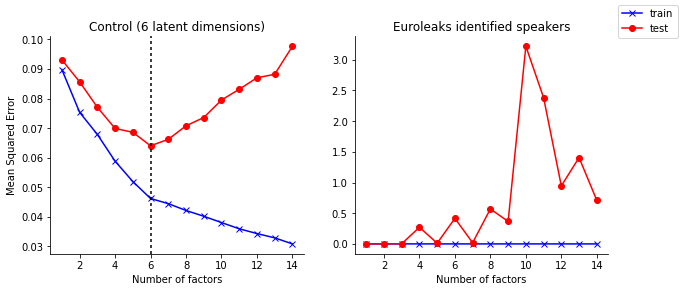

In [651]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

titles = [f'Control ({control_n_latent_dim} latent dimensions)', 'Euroleaks identified speakers']
train_errs = [control_train_err, leaks_train_err]
test_errs = [control_test_err, leaks_test_err]

for i, ax in enumerate(axes):
    
    ax.plot(*list(zip(*train_errs[i])), '-xb', label='train')
    ax.plot(*list(zip(*test_errs[i])), '-or', label='test')
    ax.set_title(titles[i])
    #ax.legend()
        
    ax.set_xlabel('Number of factors')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i == 0:
        ax.set_ylabel('Mean Squared Error')
        ax.axvline(control_n_latent_dim, color='k', dashes=[2,2])
    
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
fig.subplots_adjust(right=0.9)
    
#fig.tight_layout()
fig.savefig('../figures/nmf-speaker-validation.pdf')

In [653]:
print(f'Percent of entries in X which are 0: {np.round(np.mean(leaks_X.A > 0)*100,2)} %')

Percent of entries in X which are 0: 16.2 %


#### 3D plot

In [656]:
nmf = NMF(n_components=3,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0, # important sicne otherwise the resulting plot will be different each run
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(leaks_X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (31, 3)
H shape: (3, 1649)


In [657]:
# get speaker labels (name + entity they represent)
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

institutions = ['ECB', 'IMF', 'European Commission', 'ESM', 'EFC']
markers = ['\u2020', '\u2021']
labels = identified_speakers.to_series().apply(lambda s: 
        f'{markers[0] if speaker_to_entity[s] in institutions else markers[1]} {s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})').to_numpy()


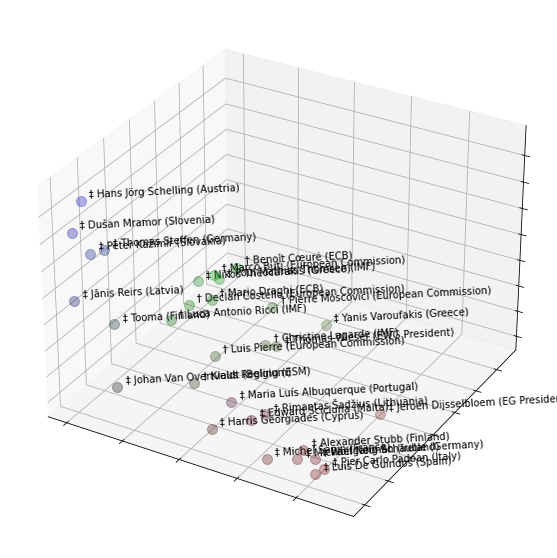

In [658]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# remove axis ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for point, label in zip(W, labels):

    x,y,z = point
    ax.scatter( x, y, z,
                color=(x,y,z),
                edgecolor=None,
                alpha=0.3,
                s=100)
    
    #jx, jy, jz = np.random.normal(0, 0.01, 3)
    jx, jy, jz = (0.01,0.01,0.01)
    
    ax.text(x + jx,
            y + jy,
            z + jz,
            label,
            zdir=(1,1,0))

#### clustering
Each axis captures the base topic of a particular document cluster, and each document is represented as an additive combination of the base topics. The cluster membership of each document can be easily determined by finding the base topic (the axis) with which the document has the largest projection value.

In [404]:
print(f'There are {len(identified_speakers)} speakers.')

There are 31 speakers.


In [408]:
number_of_clusters = 3

nmf = NMF(n_components=number_of_clusters,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(leaks_X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (31, 3)
H shape: (3, 1649)


In [411]:
from collections import defaultdict

clusters = defaultdict(list)

for speaker, cluster in  zip(identified_speakers, W.argmax(axis=1)):
    clusters[cluster].append(speaker)

In [412]:
for key,values in clusters.items():
    print(f'cluster {key}:')
    for v in values:
        print(f'\t{v}')
    print()

cluster 0:
	alexander stubb
	edward scicluna
	harris georgiades
	jeroen dijsselbloem
	johan van overtveldt
	luis de guindos
	maria luís albuquerque
	michael noonan
	michel sapin
	pier carlo padoan
	rimantas šadžius
	wolfgang schäuble

cluster 1:
	benoît cœuré
	christine lagarde
	declan costello
	klaus regling
	luca antonio ricci
	luis pierre
	marco buti
	mario draghi
	nikos theocarakis
	pierre moscovici
	poul mathias thomsen
	thomas wieser
	yanis varoufakis

cluster 2:
	dušan mramor
	hans jörg schelling
	jānis reirs
	peter kažimír
	thomas steffen
	tooma



In [414]:
topics = get_topics_terms_weights(H, leaks_vectorizer.get_feature_names())

print_topics_udf(topics, total_topics=3, num_terms=30, display_weights=True)

Topic #1 with weights
[('referendum', 0.3), ('program', 0.29), ('agree', 0.21), ('letter', 0.19), ('time', 0.19), ('decision', 0.17), ('document', 0.17), ('political', 0.17), ('meeting', 0.15), ('come', 0.15), ('greek_authority', 0.15), ('greek_people', 0.15), ('like', 0.15), ('process', 0.14), ('eurogroup', 0.14), ('course', 0.13), ('position', 0.13), ('today', 0.13), ('discuss', 0.13), ('mean', 0.12), ('term', 0.12), ('greek', 0.12), ('greek_government', 0.12), ('new', 0.12), ('end', 0.11), ('difficult', 0.11), ('right', 0.11), ('aide_memoire', 0.11), ('table', 0.11), ('fully', 0.11)]

Topic #2 with weights
[('reform', 0.28), ('discussion', 0.22), ('measure', 0.22), ('government', 0.19), ('policy', 0.19), ('area', 0.18), ('authority', 0.15), ('bank', 0.14), ('process', 0.14), ('number', 0.14), ('brussels_group', 0.13), ('issue', 0.13), ('technical', 0.12), ('list', 0.12), ('liquidity', 0.12), ('pension', 0.12), ('term', 0.12), ('mean', 0.11), ('fiscal', 0.11), ('target', 0.11), ('lev

## document = date

In [736]:
leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by speaker
grouped = leaks.drop(columns=['speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))
# get speaker labels
dates = grouped.index

# preprocess
leaks_documents = [
    ' '.join([token.lemma_.lower() for sentence in nlp(doc).sents for token in sentence
              if filter_token(token)
             ])
             for doc in grouped.values
]

# leave out empty documents
leaks_documents = [d for d in leaks_documents if len(d)>1]

print(f'There are {len(leaks_documents)} documents.')

# apply collocations
leaks_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in leaks_documents]

# need to filter out unidentified speakers first?

# tfidf
leaks_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2,
                                   max_df=0.75,
                                   smooth_idf=True,
                                   sublinear_tf=False)

leaks_X = leaks_vectorizer.fit_transform(leaks_documents)

There are 12 documents.


In [737]:
int(12*0.75)

9

### cross validation to find number of latent dimenstions

In [670]:
# control with 6 latent dimensions
control_n_latent_dim = 3
M, N = 100, 150
noise = .8

U = np.random.rand(M, control_n_latent_dim)
Vt = np.random.rand(control_n_latent_dim, N)
control_X = np.dot(U, Vt) + noise*np.random.rand(M, N)

control_train_err, control_test_err = validate_nmf(control_X)

In [673]:
# validate tfidf matrix
leaks_train_err, leaks_test_err = validate_nmf(leaks_X.A)

LinAlgError: Singular matrix

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

titles = [f'Control ({control_n_latent_dim} latent dimensions)', 'Euroleaks identified speakers']
train_errs = [control_train_err, leaks_train_err]
test_errs = [control_test_err, leaks_test_err]

for i, ax in enumerate(axes):
    
    ax.plot(*list(zip(*train_errs[i])), '-xb', label='train')
    ax.plot(*list(zip(*test_errs[i])), '-or', label='test')
    ax.set_title(titles[i])
    #ax.legend()
        
    ax.set_xlabel('Number of factors')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i == 0:
        ax.set_ylabel('Mean Squared Error')
        ax.axvline(control_n_latent_dim, color='k', dashes=[2,2])
    
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
fig.subplots_adjust(right=0.9)
    
#fig.tight_layout()
fig.savefig('../figures/nmf-date-validation.pdf')

In [ ]:
print(f'Percent of entries in X which are 0: {np.round(np.mean(leaks_X.A > 0)*100,2)} %')

### 3D plot

In [738]:
nmf = NMF(n_components=3,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0, # important sicne otherwise the resulting plot will be different each run
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(leaks_X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (12, 3)
H shape: (3, 1590)


In [739]:
# from: https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

<ipython-input-739-58bbdb165bd1>:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


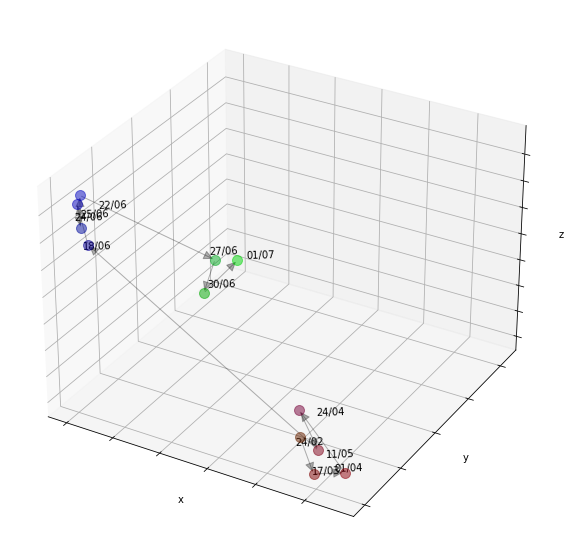

In [740]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# remove axis ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for i, label in enumerate(dates):

    point = W[i,:]
    
    # plot
    x,y,z = point
    c = (min(max(x,0),1),min(max(y,0),1),min(max(z,0),1))
    ax.scatter( x, y, z,
                color=c,
                edgecolor=None,
                alpha=0.5,
                s=100)
    
    # annotate
    jx, jy, jz = np.random.normal(0, 0.02, 3)
    ax.text(x + jx,
            y + jy,
            z + jz,
            pd.to_datetime(label).strftime('%d/%m'),
            zdir=(1,1,0))
    
    # add arrow
    if i>0:
        previous_point = W[i-1,:]
        px, py, pz = previous_point
        #ax.arrow((px,x),(py,y),(pz,z),
        #        color='black',
        #        arrowstyle='-|>')
        #ax.quiver(px,py,pz,
        #          x,y,z,
        #          color='black',
        #          alpha=0.3,
        #          lw=2)
        arrow = Arrow3D([px,x],[py,y],[pz,z],
                        mutation_scale=20,
                        lw=1,
                        arrowstyle='-|>',
                        color='k',
                        alpha=0.3)
        ax.add_artist(arrow)

### clustering
Each axis captures the base topic of a particular document cluster, and each document is represented as an additive combination of the base topics. The cluster membership of each document can be easily determined by finding the base topic (the axis) with which the document has the largest projection value.

In [741]:
print(f'There are {len(dates)} dates.')

There are 12 dates.


In [742]:
number_of_clusters = 3

nmf = NMF(n_components=number_of_clusters,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(leaks_X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (12, 3)
H shape: (3, 1590)


In [743]:
from collections import defaultdict

clusters = defaultdict(list)

for date, cluster in  zip(dates, W.argmax(axis=1)):
    clusters[cluster].append(pd.to_datetime(date).strftime('%d/%m'))

In [744]:
for key,values in clusters.items():
    print(f'cluster {key}:')
    for v in values:
        print(f'\t{v}')
    print()

cluster 0:
	24/02
	17/03
	01/04
	24/04
	11/05

cluster 2:
	18/06
	22/06
	24/06
	25/06

cluster 1:
	27/06
	30/06
	01/07



In [745]:
topics = get_topics_terms_weights(H, leaks_vectorizer.get_feature_names())

print_topics_udf(topics, total_topics=3, num_terms=30, display_weights=True)

Topic #0 with weights
[('liquidity', 0.38), ('progress', 0.29), ('athens', 0.24), ('area', 0.23), ('april', 0.2), ('brussels_group', 0.19), ('public', 0.19), ('authority', 0.18), ('significant', 0.16), ('commitment', 0.15), ('bill', 0.15), ('previous', 0.14), ('intention', 0.14), ('help', 0.13), ('successful_conclusion_review', 0.13), ('target', 0.12), ('euro_working_group', 0.12), ('overall', 0.11), ('arrangement', 0.11), ('friday', 0.11), ('key', 0.11), ('law', 0.1), ('system', 0.1), ('require', 0.1), ('improve', 0.1), ('consider', 0.09), ('privatization', 0.09), ('exist', 0.09), ('communication', 0.09), ('unilateral', 0.09)]

Topic #1 with weights
[('referendum', 0.57), ('letter', 0.43), ('greek_people', 0.27), ('second_letter', 0.23), ('vote', 0.15), ('prime_minister', 0.12), ('esm', 0.11), ('sunday', 0.11), ('sla', 0.11), ('mandate', 0.1), ('prior_action', 0.1), ('stance', 0.09), ('yesterday', 0.08), ('package', 0.08), ('amendment', 0.08), ('send', 0.07), ('sign', 0.07), ('tomorro

In [701]:
# print all word for a topic (in a format that is easy to copy to over to overleaf)
# for word in topics[0][:,0]:
#     print(word)

# Communiques

In [746]:
communiques = pd.read_csv('../data/communiques/cleaned.csv')

# group by speaker
grouped = communiques.drop(columns=['title']).groupby('date').apply(lambda s: ' '.join(s.story))
# get speaker labels
dates = grouped.index

# preprocess
comm_documents = [
    ' '.join([token.lemma_.lower() for sentence in nlp(doc).sents for token in sentence
              if filter_token(token)
             ])
             for doc in grouped.values
]

# leave out empty documents
comm_documents = [d for d in comm_documents if len(d)>1]

print(f'There are {len(comm_documents)} documents.')

# apply collocations
comm_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in comm_documents]

# need to filter out unidentified speakers first?

# tfidf
comm_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=2,
                                   max_df=0.75,
                                   smooth_idf=True,
                                   sublinear_tf=False)

comm_X = comm_vectorizer.fit_transform(comm_documents)

There are 13 documents.


### cross validation to find number of latent dimenstions

In [708]:
# control with 6 latent dimensions
control_n_latent_dim = 3
M, N = 100, 150
noise = .8

U = np.random.rand(M, control_n_latent_dim)
Vt = np.random.rand(control_n_latent_dim, N)
control_X = np.dot(U, Vt) + noise*np.random.rand(M, N)

control_train_err, control_test_err = validate_nmf(control_X)

In [709]:
# validate tfidf matrix
comm_train_err, comm_test_err = validate_nmf(comm_X.A)

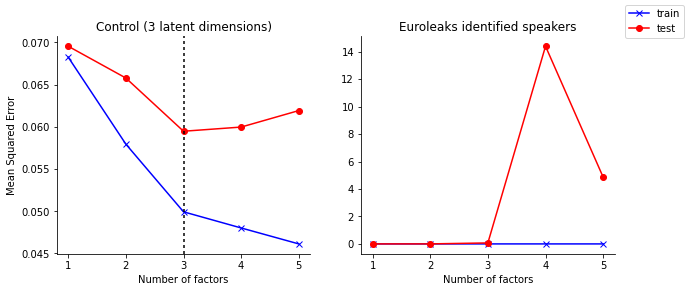

In [710]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

titles = [f'Control ({control_n_latent_dim} latent dimensions)', 'Communiques dates']
train_errs = [control_train_err, comm_train_err]
test_errs = [control_test_err, comm_test_err]

for i, ax in enumerate(axes):
    
    ax.plot(*list(zip(*train_errs[i])), '-xb', label='train')
    ax.plot(*list(zip(*test_errs[i])), '-or', label='test')
    ax.set_title(titles[i])
    #ax.legend()
        
    ax.set_xlabel('Number of factors')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i == 0:
        ax.set_ylabel('Mean Squared Error')
        ax.axvline(control_n_latent_dim, color='k', dashes=[2,2])
    
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
fig.subplots_adjust(right=0.9)
    
#fig.tight_layout()
fig.savefig('../figures/nmf-date-comm-validation.pdf')

In [712]:
print(f'Percent of entries in X which are 0: {np.round(np.mean(comm_X.A > 0)*100,2)} %')

Percent of entries in X which are 0: 26.41 %


### 3D plot

In [747]:
nmf = NMF(n_components=3,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          random_state=0,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(comm_X.A)
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (13, 3)
H shape: (3, 413)


In [748]:
# from: https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

<ipython-input-748-58bbdb165bd1>:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


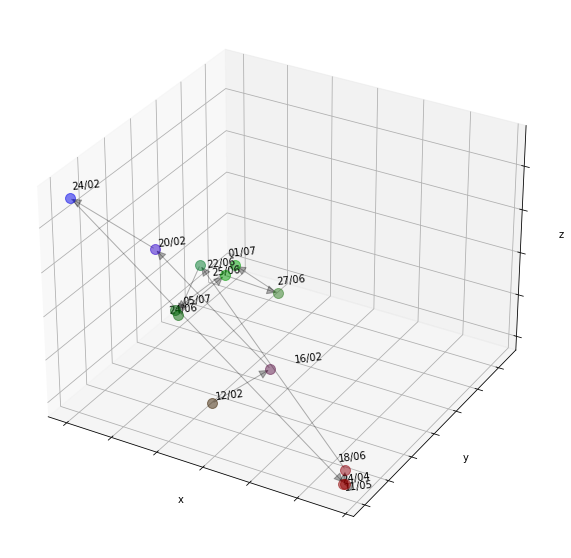

In [755]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# remove axis ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for i, label in enumerate(dates):

    point = W[i,:]
    
    # plot
    x,y,z = point
    c = (min(max(x,0),1),min(max(y,0),1),min(max(z,0),1))
    ax.scatter( x, y, z,
                color=c,
                edgecolor=None,
                alpha=0.5,
                s=100)
    
    # annotate
    jx, jy, jz = np.random.normal(0, 0.02, 3)
    ax.text(x + jx,
            y + jy,
            z + jz,
            pd.to_datetime(label).strftime('%d/%m'),
            zdir=(1,1,0))
    
    # add arrow
    if i>0:
        previous_point = W[i-1,:]
        px, py, pz = previous_point
        #ax.arrow((px,x),(py,y),(pz,z),
        #        color='black',
        #        arrowstyle='-|>')
        #ax.quiver(px,py,pz,
        #          x,y,z,
        #          color='black',
        #          alpha=0.3,
        #          lw=2)
        arrow = Arrow3D([px,x],[py,y],[pz,z],
                        mutation_scale=20,
                        lw=1,
                        arrowstyle='-|>',
                        color='k',
                        alpha=0.3)
        ax.add_artist(arrow)

### clustering
Each axis captures the base topic of a particular document cluster, and each document is represented as an additive combination of the base topics. The cluster membership of each document can be easily determined by finding the base topic (the axis) with which the document has the largest projection value.

In [756]:
print(f'There are {len(dates)} dates.')

There are 13 dates.


In [762]:
number_of_clusters = 3

nmf = NMF(n_components=number_of_clusters,
          init='nndsvd',
          beta_loss='frobenius',
          max_iter=1000,
          alpha=0,
          l1_ratio=0)

W = nmf.fit_transform(comm_X.toarray())
H = nmf.components_

print(f'W shape: {W.shape}')
print(f'H shape: {H.shape}')

W shape: (13, 3)
H shape: (3, 413)


In [763]:
from collections import defaultdict

clusters = defaultdict(list)

for date, cluster in  zip(dates, W.argmax(axis=1)):
    clusters[cluster].append(pd.to_datetime(date).strftime('%d/%m'))

In [764]:
for key,values in clusters.items():
    print(f'cluster {key}:')
    for v in values:
        print(f'\t{v}')
    print()

cluster 0:
	12/02
	16/02
	24/04
	11/05
	18/06

cluster 2:
	20/02
	24/02

cluster 1:
	22/06
	24/06
	25/06
	27/06
	01/07
	05/07



In [765]:
topics = get_topics_terms_weights(H, comm_vectorizer.get_feature_names())

print_topics_udf(topics, total_topics=3, num_terms=30, display_weights=True)

Topic #0 with weights
[('program', 0.31), ('discussion', 0.28), ('framework', 0.25), ('progress', 0.24), ('euro_area', 0.22), ('fiscal', 0.21), ('greece', 0.2), ('ireland', 0.19), ('today', 0.19), ('remain', 0.18), ('important', 0.18), ('economic', 0.16), ('cyprus', 0.16), ('agreement', 0.15), ('time', 0.15), ('growth', 0.14), ('situation', 0.14), ('good', 0.14), ('regular', 0.14), ('review', 0.14), ('portugal', 0.13), ('issue', 0.13), ('policy', 0.13), ('agree', 0.13), ('new', 0.13), ('continue', 0.13), ('reform', 0.13), ('talk', 0.13), ('start', 0.13), ('financial', 0.12)]

Topic #1 with weights
[('proposal', 0.48), ('inform', 0.22), ('referendum', 0.22), ('greek', 0.22), ('state_play', 0.19), ('talk', 0.19), ('reconvene', 0.18), ('situation', 0.18), ('discuss', 0.14), ('greek_government', 0.14), ('outcome', 0.14), ('work', 0.14), ('greece', 0.13), ('meeting', 0.13), ('political', 0.13), ('heads', 0.12), ('prepare', 0.12), ('far', 0.11), ('negotiation', 0.11), ('ground', 0.11), ('fin